In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, BatchNormalization

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define the path to your data directory
data_dir = '/content/drive/MyDrive/grape/train'

# Define image dimensions
img_width, img_height = 224, 224
input_shape = (img_width, img_height, 3)

# Define batch size and number of epochs
batch_size = 32
epochs = 30
validation_split = 0.2  # 20% of the data will be used for validation

In [ ]:
# Create an ImageDataGenerator for data preprocessing and augmentation
datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=validation_split  # Set the validation split here
)

# Create a data generator with validation split
data_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'  # Specify 'training' or 'validation'
)

validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'  # Specify 'training' or 'validation'
)


Found 5821 images belonging to 4 classes.
Found 1454 images belonging to 4 classes.


In [ ]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

# Load pre-trained ResNet152 model with pre-trained weights
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)

# Create the final model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(4, activation='softmax')(x)  # Assuming 4 classes for maize diseases
model = Model(inputs=base_model.input, outputs=x)

# Freeze the layers of the ResNet model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


29084464/29084464 [==============================] - 3s 0us/step


In [6]:
from tensorflow.keras.callbacks import EarlyStopping

# Train the model with callbacks
history = model.fit(
    data_generator,
    steps_per_epoch=data_generator.samples // batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

Epoch 1/10
181/181 [==============================] - 4088s 22s/step - loss: 0.2058 - accuracy: 0.9202 - val_loss: 0.0699 - val_accuracy: 0.9694
Epoch 2/10
181/181 [==============================] - 135s 746ms/step - loss: 0.0908 - accuracy: 0.9686 - val_loss: 0.0578 - val_accuracy: 0.9792
Epoch 3/10
181/181 [==============================] - 116s 642ms/step - loss: 0.0649 - accuracy: 0.9758 - val_loss: 0.0541 - val_accuracy: 0.9792
Epoch 4/10
181/181 [==============================] - 135s 748ms/step - loss: 0.0473 - accuracy: 0.9808 - val_loss: 0.0576 - val_accuracy: 0.9799
Epoch 5/10
181/181 [==============================] - 116s 640ms/step - loss: 0.0702 - accuracy: 0.9731 - val_loss: 0.1831 - val_accuracy: 0.9264
Epoch 6/10
181/181 [==============================] - 135s 747ms/step - loss: 0.0698 - accuracy: 0.9748 - val_loss: 0.0642 - val_accuracy: 0.9778
Epoch 7/10
181/181 [==============================] - 120s 665ms/step - loss: 0.0502 - accuracy: 0.9831 - val_loss: 0.0494 - 

In [7]:
# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")


46/46 [==============================] - 24s 529ms/step - loss: 0.0553 - accuracy: 0.9794
Validation Loss: 0.0553, Validation Accuracy: 0.9794


In [ ]:
import matplotlib.pyplot as plt
# Extract training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Training Accuracy')
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [9]:
# Save the entire model to a file
model.save('my_resnet.h5')

# Optionally, you can also save just the model weights
model.save_weights('my_model_resnet.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [10]:
import os
import random
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, decode_predictions


In [11]:
model = load_model(r"/content/my_resnet.h5")

In [12]:
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img


In [13]:
class_names = ["Black Rot", "ESCA", "Healthy","Leaf Blight"]

1/1 [==============================] - 4s 4s/step


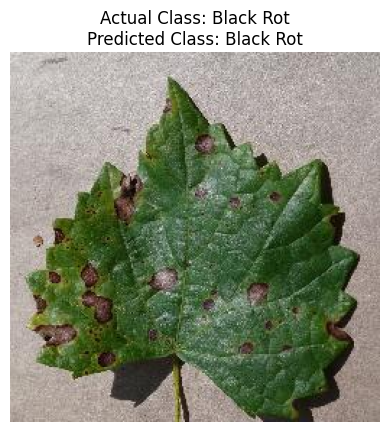

1/1 [==============================] - 0s 36ms/step


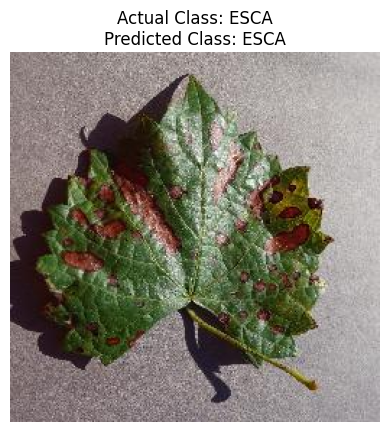

1/1 [==============================] - 0s 29ms/step


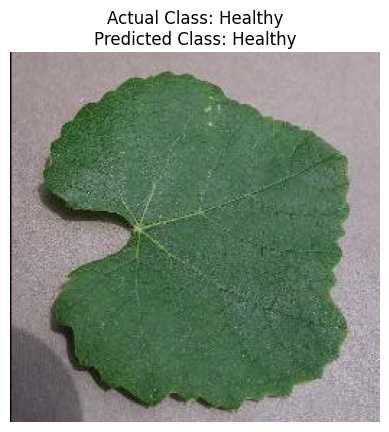

1/1 [==============================] - 0s 27ms/step


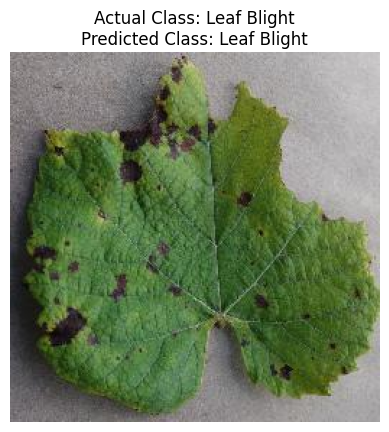

In [14]:
import matplotlib.pyplot as plt
# Define the base directory
base_directory = "/content/drive/MyDrive/grape/test"

# Iterate through the subdirectories, randomly select an image from each, and make predictions
for class_name in class_names:
    class_directory = os.path.join(base_directory, class_name)
    if not os.path.exists(class_directory):
        continue

    image_files = os.listdir(class_directory)
    if len(image_files) == 0:
        continue

    random_image_file = random.choice(image_files)
    img_path = os.path.join(class_directory, random_image_file)

    # Preprocess the image
    img = preprocess_image(img_path)

    # Make a prediction
    predictions = model.predict(img)
    predicted_class_index = np.argmax(predictions)
    predicted_class = class_names[predicted_class_index]

    # Load and display the image
    img = image.load_img(img_path)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Actual Class: {class_name}\nPredicted Class: {predicted_class}")
    plt.show()  # This line is correctly indented now
